In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## libraries to create the model 
from tensorflow.keras.layers import  MaxPool1D, Input, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import  Dense, Activation, Dropout, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K

In [4]:
# For reproducibility
np.random.seed(12)
tf.random.set_seed(12)
random.seed(1)

In [5]:
dir_saved_data = "/content/drive/My Drive/ASHRAEData/"
dir_saved_model = "/content/drive/My Drive/ASHRAEData/" 

In [6]:
## CAN BE CHANGED 

## change these lists as per model's input 
site_id= 0 

## window length 
seq_length = 24 

## name of the model for which data is prepared
model_name = 'Baseline_Conv1'

In [7]:
## CAN BE CHANGED 

BATCH_SIZE_TEST = 32 ## Test batch size
BATCH_SIZE_VAL = 16 ## Validation batch size

In [8]:
## Creating the model again to load weights
tf.keras.backend.clear_session()

In [9]:
def generate_model_autoencoder1(input_len, name):
  ## Creating the Non Conditional Convolutional De-noising Autoencoder Model

  ## input layer
  input_encoder = Input(shape=(input_len,)) 
  ## introducing Noise (can be changed)
  ip = Dropout(0.05)(input_encoder) 
  encoder = Reshape((input_len,1))(ip)

  ## First layer of the encoder 
  encoder = Conv1D(12, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(encoder)
  encoder = MaxPool1D(pool_size=2, data_format='channels_last')(encoder)

  ## Second layer of the encoder 
  encoder = Conv1D(6, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(encoder)  
  encoder = MaxPool1D(pool_size=2, data_format='channels_last')(encoder)

  ## Third and last layer of the encoder 
  encoder = Conv1D(1, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(encoder)  
  encoder = MaxPool1D(pool_size=2, data_format='channels_last')(encoder)

  ## Decoder first layer
  decoder = Conv1D(1, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(encoder)  
  decoder = UpSampling1D(size=2)(decoder)

  ## Decoder second layer
  decoder = Conv1D(6, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(decoder)  
  decoder = UpSampling1D(size=2)(decoder)

  ## Decoder third layer
  decoder = Conv1D(12, 2, strides=1, padding='same', data_format='channels_last', activation='tanh')(decoder)  
  decoder = UpSampling1D(size=2)(decoder)

  ## output layer
  decoded = decoder = Conv1D(1, 2, strides=1, padding='same', data_format='channels_last', activation='relu')(decoder) 
  
  ## initalizing keras.Model instance
  model = Model(input_encoder, decoded, name = name)

  return model

In [10]:
## Initialize the model
model = generate_model_autoencoder1(seq_length,  model_name)

In [11]:
## Reading saved data Non - Anomalous
os.chdir(dir_saved_data)

# ## Reading training data
# with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/non_anom/train_data.pkl", 'rb') as f:
#   Y_train_non_anom = pickle.load(f)

## Reading validation data
with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/non_anom/val_data.pkl", 'rb') as f:
  Y_val_non_anom = pickle.load(f)

## Reading test data
with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/non_anom/test_data.pkl", 'rb') as f:
  Y_test_non_anom = pickle.load(f)

In [12]:
## Reading saved data Anomalous
os.chdir(dir_saved_data)

# ## Reading training data
# with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/anom/train_data.pkl", 'rb') as f:
#   Y_train_non_anom = pickle.load(f)

## Reading validation data
with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/anom/val_data.pkl", 'rb') as f:
  Y_val_anom = pickle.load(f)

## Reading test data
with open("./Baseline_data/Not_Conditional/"+ "site_id_" + str(site_id)+"/anom/test_data.pkl", 'rb') as f:
  Y_test_anom = pickle.load(f)

In [15]:
os.chdir(dir_saved_model)

In [16]:
## Loading weights for the model
model.load_weights('./'+ model_name + "/" + "_site_id_"+ str(site_id) + '.ckpt')

In [17]:
## Creating Test annd Validation tf.dat.Dataset objects to do predictions for Non Anomalous

## creating tf.Dataset objects Test Non Anomalous
test_dataset_non_anom = tf.data.Dataset.from_tensor_slices((Y_test_non_anom,Y_test_non_anom))

## creating tf.Dataset objects Validation Non Anomalous
val_dataset_non_anom = tf.data.Dataset.from_tensor_slices((Y_val_non_anom,Y_val_non_anom))

## Setting the batch size
test_dataset_non_anom = test_dataset_non_anom.batch(BATCH_SIZE_TEST)
val_dataset_non_anom = val_dataset_non_anom.batch(BATCH_SIZE_VAL)

print(test_dataset_non_anom)
print(val_dataset_non_anom)

<BatchDataset shapes: ((None, 24, 1), (None, 24, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 24, 1), (None, 24, 1)), types: (tf.float32, tf.float32)>


In [18]:
## Creating Test annd Validation tf.dat.Dataset objects to do predictions for Non Anomalous

## creating tf.Dataset objects Test Anomalous
test_dataset_anom = tf.data.Dataset.from_tensor_slices((Y_test_anom,Y_test_anom))

## creating tf.Dataset objects Validation Anomalous
val_dataset_anom = tf.data.Dataset.from_tensor_slices((Y_val_anom,Y_val_anom))

## Setting the batch size
test_dataset_anom = test_dataset_anom.batch(BATCH_SIZE_TEST)
val_dataset_anom = val_dataset_anom.batch(BATCH_SIZE_VAL)

print(test_dataset_anom)
print(val_dataset_anom)

<BatchDataset shapes: ((None, 24, 1), (None, 24, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 24, 1), (None, 24, 1)), types: (tf.float32, tf.float32)>


In [24]:
## Validation dataset Non Anomalous Ground Truth
val_arr_0 = np.zeros((1,24))
for i in range(len(Y_val_non_anom)):
  val_arr_0 = np.concatenate([val_arr_0, Y_val_non_anom[i].reshape(1, 24)], axis=0)
val_arr_0 = np.delete(val_arr_0, (0), axis=0)

## Validation dataset Anomalous Ground Truth
val_arr_1 = np.zeros((1,24))
for i in range(len(Y_val_anom)):
  val_arr_1 = np.concatenate([val_arr_1, Y_val_anom[i].reshape(1, 24)], axis=0)
val_arr_1 = np.delete(val_arr_1, (0), axis=0)

In [25]:
## Test dataset Non Anomalous Ground Truth
test_arr_0 = np.zeros((1,24))
for i in range(len(Y_test_non_anom)):
  test_arr_0 = np.concatenate([test_arr_0, Y_test_non_anom[i].reshape(1, 24)], axis=0)
test_arr_0 = np.delete(test_arr_0, (0), axis=0)

## Test dataset Anomalous Ground Truth
test_arr_1 = np.zeros((1,24))
for i in range(len(Y_test_anom)):
  test_arr_1 = np.concatenate([test_arr_1, Y_test_anom[i].reshape(1, 24)], axis=0)
test_arr_1 = np.delete(test_arr_1, (0), axis=0)

In [26]:
# outlier label Validation data 
anomaly_label_val = np.concatenate([np.zeros((len(Y_val_non_anom))), np.ones((len(Y_val_anom)))], axis=0)

# outlier label Test Data
anomaly_label_test = np.concatenate([np.zeros((len(Y_test_non_anom))), np.ones((len(Y_test_anom)))], axis=0)

In [27]:
def calc_mse(y_true,y_pred):
  return ((y_true - y_pred)**2).mean(axis=1)

In [29]:
## predicted windows Validation - Non Anomalous
pred_val_non_anom = model.predict(val_dataset_non_anom)
pred_val_non_anom = pred_val_non_anom.reshape((pred_val_non_anom.shape[0], pred_val_non_anom.shape[1]))

#Validation score - Non Anomalous 
val_anomaly_score_non_anom = calc_mse(val_arr_0, pred_val_non_anom)

## predicted windows Validation - Anomalous
pred_val_anom = model.predict(val_dataset_anom)
pred_val_anom = pred_val_anom.reshape((pred_val_anom.shape[0], pred_val_anom.shape[1]))
#Validation score - Anomalous 
val_anomaly_score_anom = calc_mse(val_arr_1, pred_val_anom)

# anomaly score - Validation
val_score = np.concatenate([val_anomaly_score_non_anom, val_anomaly_score_anom], axis=0)

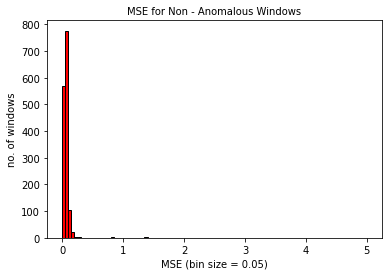

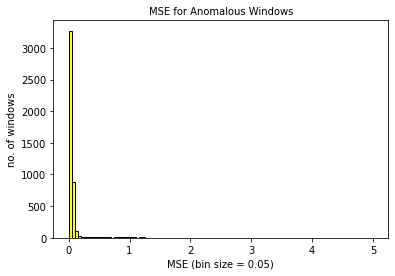

In [30]:
for i, binwidth in enumerate([0.05]): # log_7
      # Draw the plot
      plt.hist(val_anomaly_score_non_anom, color = 'red', edgecolor = 'black', bins = int((5)/binwidth),range=(0,5), density=False)
      plt.title("MSE for Non - Anomalous Windows", fontsize=10)
      plt.xlabel('MSE (bin size = 0.05)', fontsize=10)
      plt.ylabel('no. of windows', fontsize=10)
      # plt.savefig("Non_Anom_MSE_Model.pdf")
      plt.show()
      plt.hist(val_anomaly_score_anom, color = 'yellow', edgecolor = 'black', bins = int((5)/binwidth),range=(0,5), density=False)
      # , bins = int((5)/binwidth),range=(0,5)
      plt.title("MSE for Anomalous Windows", fontsize=10)
      # # Title and labels
      # plt.title('Histogram with Binwidth ='+ str(binwidth))
      plt.xlabel('MSE (bin size = 0.05)', fontsize=10)
      plt.ylabel('no. of windows', fontsize=10)
      # plt.savefig("Anom_MSE_Model_2.pdf")
      plt.show()

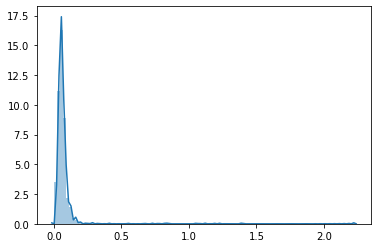

In [31]:
sns.distplot(val_anomaly_score_non_anom, bins=100)

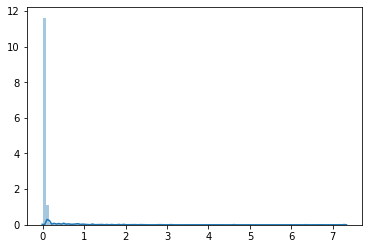

In [32]:
sns.distplot(val_anomaly_score_anom, bins = 100)

In [34]:
## predicted windows Test - Non Anomalous
pred_test_non_anom = model.predict(test_dataset_non_anom)
pred_test_non_anom = pred_test_non_anom.reshape((pred_test_non_anom.shape[0], pred_test_non_anom.shape[1]))
# Test score - Non Anomalous 
test_anomaly_score_non_anom = calc_mse(test_arr_0, pred_test_non_anom)

## predicted windows Test - Anomalous
pred_test_anom = model.predict(test_dataset_anom)
pred_test_anom = pred_test_anom.reshape((pred_test_anom.shape[0], pred_test_anom.shape[1]))
# Test score - Anomalous 
test_anomaly_score_anom = calc_mse(test_arr_1, pred_test_anom)

# anomaly score - Test
test_score = np.concatenate([test_anomaly_score_non_anom, test_anomaly_score_anom], axis=0)

In [35]:
# set threshold on the validation data 
threshold = 0.2

In [36]:
print("threshold : ", threshold)
# convet scores to label using the calculated labels 
val_label_pred = (val_score > threshold).astype('int')

threshold :  0.2


In [37]:
# evaluate and print the results on Validation data 
print("\nOn Validation Data:")
tn, fp, fn, tp = metrics.confusion_matrix(anomaly_label_val, val_label_pred).ravel()
p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print("Precision : {}".format(p))
print("Recall : {}".format(r))
print("F1 score : {}".format(f1))


On Validation Data:
Precision : 0.921311475409836
Recall : 0.06128680479825518
F1 score : 0.1149284253578732


In [40]:
print("threshold : ", threshold)
# convet scores to label using the calculated labels 
test_label_pred = (test_score > threshold).astype('int')

threshold :  0.2


In [41]:
# evaluate and print the results on Validation data 
print("\nOn Test Data:")
tn, fp, fn, tp = metrics.confusion_matrix(anomaly_label_test, test_label_pred).ravel()
p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print("Precision : {}".format(p))
print("Recall : {}".format(r))
print("F1 score : {}".format(f1))


On Test Data:
Precision : 0.9740018570102136
Recall : 0.06538677304743502
F1 score : 0.1225467289719626
